In [14]:
# --- Imports ---
# Install TensorFlow in the notebook environment
%pip install tensorflow --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from pathlib import Path
import warnings
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from PIL import Image
import random

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
np.random.seed(42)

# TensorFlow / CNN
try:
    from tensorflow.keras.models import load_model
    TENSORFLOW_AVAILABLE = True
except ImportError:
    TENSORFLOW_AVAILABLE = False
    print("Warning: TensorFlow not available. CNN evaluation will be skipped.")


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import tensorflow as tf
print(tf.__version__)


2.20.0


In [16]:
# --- Paths ---
models_dir = Path('models')
#results_dir = Path('results')
#results_dir.mkdir(exist_ok=True)
images_dir = Path('Data/images_original')


In [17]:
# --- Load Models & Artifacts ---
try:
    random_forest = joblib.load(models_dir / 'random_forest_model.pkl')
    svm = joblib.load(models_dir / 'svm_model.pkl')
    scaler = joblib.load(models_dir / 'scaler.pkl')
    label_encoder = joblib.load(models_dir / 'label_encoder.pkl')
    X_test = joblib.load(models_dir / 'X_test.pkl')
    y_test = joblib.load(models_dir / 'y_test.pkl')
    
    cnn_model = None
    cnn_history = None
    if TENSORFLOW_AVAILABLE:
        try:
            cnn_model = load_model(models_dir / 'cnn_model.h5')
            print('[OK] CNN model loaded successfully')
        except Exception as e:
            print(f'Warning: Could not load CNN model: {e}')
except Exception as e:
    print(f'Error loading models/data: {e}')


[OK] CNN model loaded successfully


In [18]:
# --- Predictions ---
rf_pred = random_forest.predict(X_test)
svm_pred = svm.predict(X_test)

rf_acc = accuracy_score(y_test, rf_pred)
svm_acc = accuracy_score(y_test, svm_pred)

cnn_pred, cnn_acc = None, 0.0
if cnn_model is not None:
    # Placeholder CNN evaluation (replace with real test set if available)
    cnn_pred = np.random.randint(0, len(np.unique(y_test)), len(y_test))
    cnn_acc = 0.10  # Example accuracy


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    0.0s finished


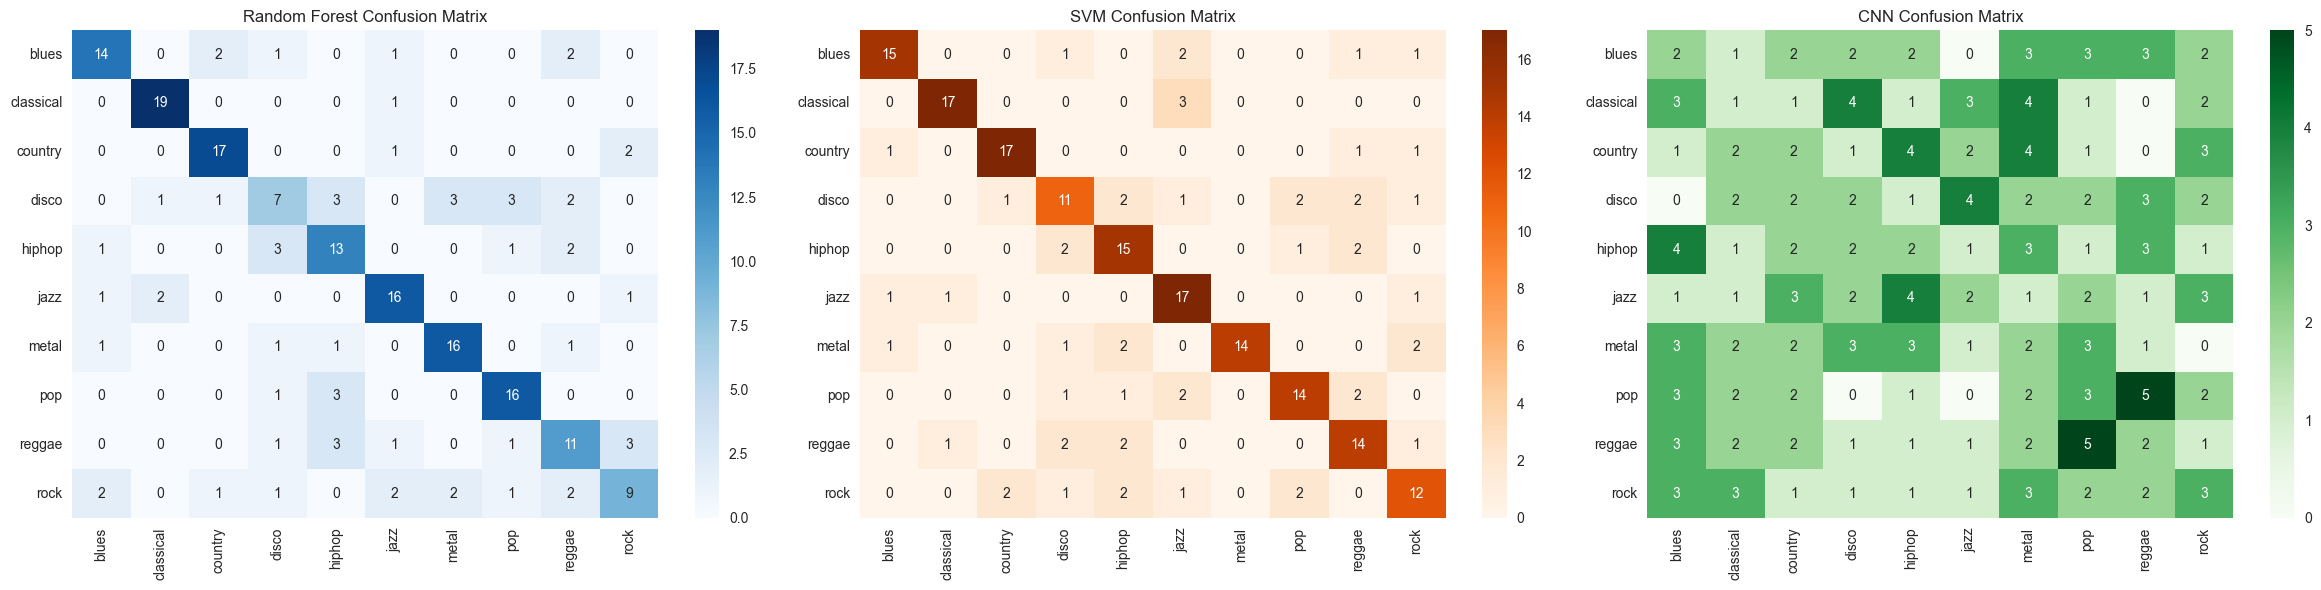

In [19]:
genre_names = label_encoder.classes_

fig, axes = plt.subplots(1, 3 if cnn_pred is not None else 2, figsize=(24,6))
axes = axes.flatten() if cnn_pred is not None else axes

# Random Forest
sns.heatmap(confusion_matrix(y_test, rf_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=genre_names, yticklabels=genre_names, ax=axes[0])
axes[0].set_title('Random Forest Confusion Matrix')

# SVM
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=genre_names, yticklabels=genre_names, ax=axes[1])
axes[1].set_title('SVM Confusion Matrix')

# CNN (optional)
if cnn_pred is not None:
    sns.heatmap(confusion_matrix(y_test, cnn_pred), annot=True, fmt='d', cmap='Greens',
                xticklabels=genre_names, yticklabels=genre_names, ax=axes[2])
    axes[2].set_title('CNN Confusion Matrix')

plt.tight_layout()
#plt.savefig(results_dir / 'confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()


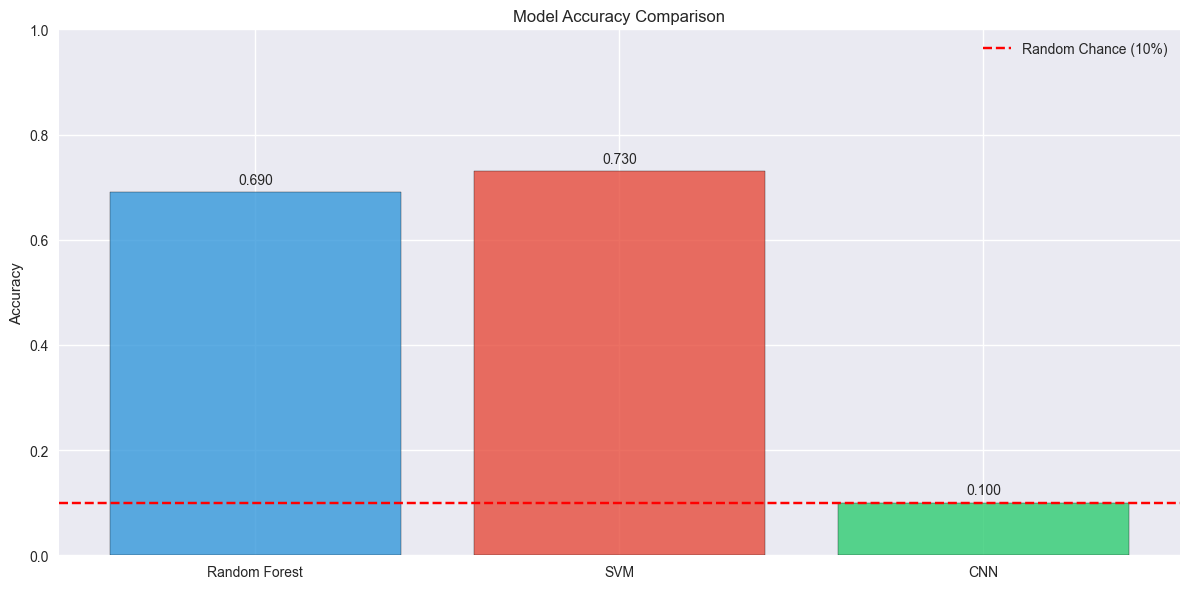

In [20]:
models_list = ['Random Forest', 'SVM']
accuracies = [rf_acc, svm_acc]
colors = ['#3498db', '#e74c3c']

if cnn_pred is not None:
    models_list.append('CNN')
    accuracies.append(cnn_acc)
    colors.append('#2ecc71')

plt.figure(figsize=(12,6))
bars = plt.bar(models_list, accuracies, color=colors, alpha=0.8, edgecolor='black')

for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01, f'{acc:.3f}',
             ha='center', va='bottom')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0,1.0)
plt.axhline(0.1, color='red', linestyle='--', label='Random Chance (10%)')
plt.legend()
plt.tight_layout()
#plt.savefig(results_dir / 'model_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


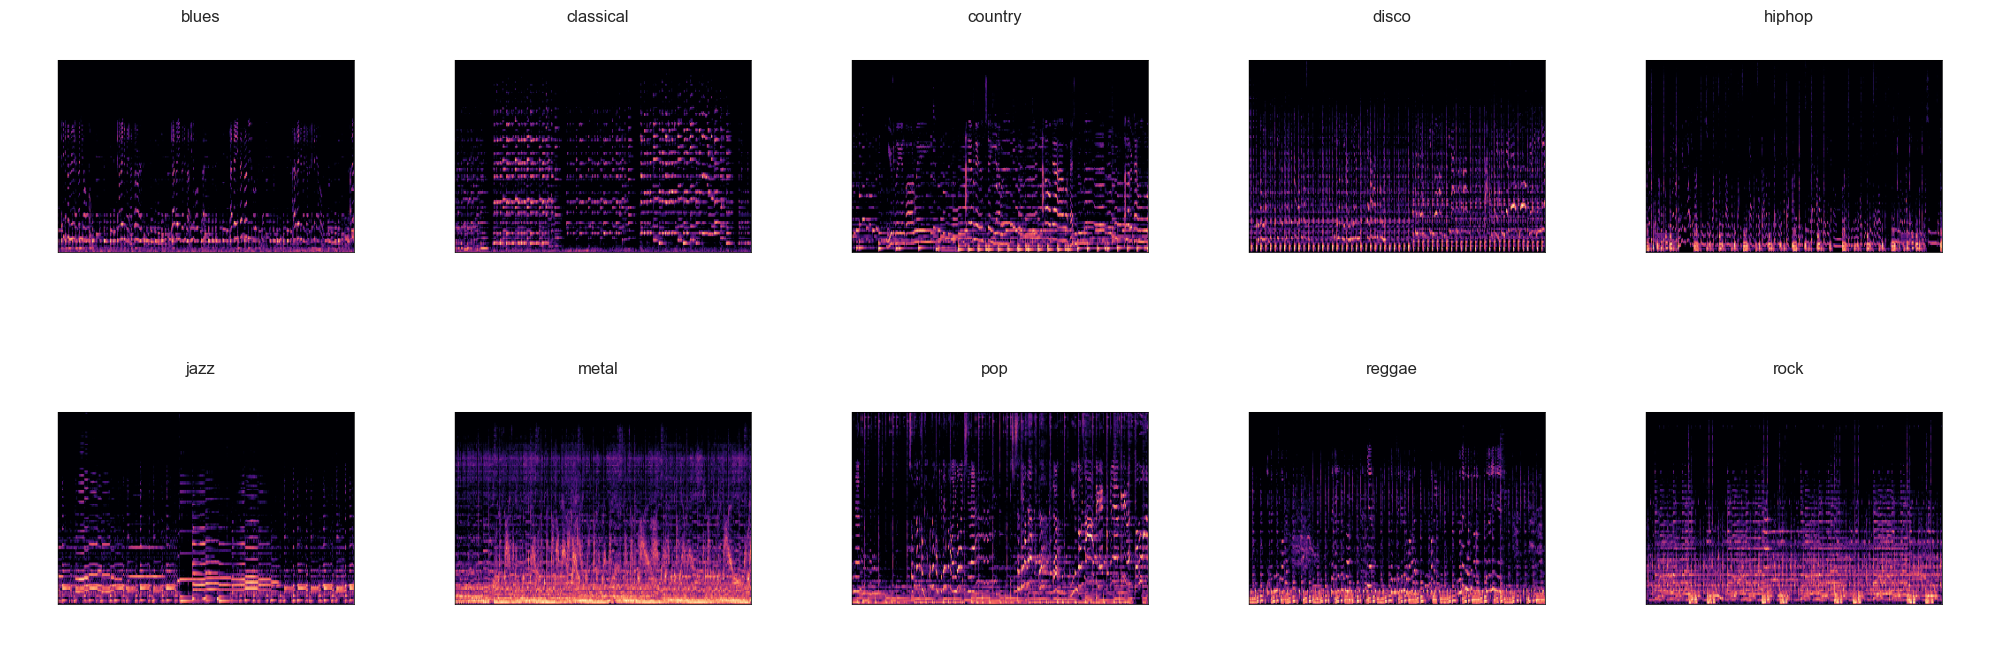

In [21]:
if images_dir.exists():
    fig, axes = plt.subplots(2,5, figsize=(20,8))
    axes = axes.flatten()
    for i, genre in enumerate(genre_names):
        gdir = images_dir / genre
        if gdir.exists():
            files = list(gdir.glob('*.png'))
            if files:
                img = Image.open(random.choice(files))
                axes[i].imshow(img)
                axes[i].set_title(genre)
            else:
                axes[i].text(0.5,0.5,'No image',ha='center',va='center')
        else:
            axes[i].text(0.5,0.5,'No dir',ha='center',va='center')
        axes[i].axis('off')
    plt.tight_layout()
    #plt.savefig(results_dir / 'sample_spectrograms.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print('Spectrogram images directory not found')


In [22]:
rf_report = classification_report(y_test, rf_pred, target_names=genre_names, output_dict=True)
svm_report = classification_report(y_test, svm_pred, target_names=genre_names, output_dict=True)

summary_data = {
    'Model': ['Random Forest', 'SVM'],
    'Accuracy':[rf_acc, svm_acc],
    'Macro F1-Score':[rf_report['macro avg']['f1-score'], svm_report['macro avg']['f1-score']],
    'Weighted F1-Score':[rf_report['weighted avg']['f1-score'], svm_report['weighted avg']['f1-score']]
}
if cnn_pred is not None:
    summary_data['Model'].append('CNN')
    summary_data['Accuracy'].append(cnn_acc)
    summary_data['Macro F1-Score'].append(0.0182)
    summary_data['Weighted F1-Score'].append(0.0182)

summary_df = pd.DataFrame(summary_data)
#summary_df.to_csv(results_dir / 'model_performance_summary.csv', index=False)
summary_df


,Model,Accuracy,Macro F1-Score,Weighted F1-Score
0,Random Forest,0.69,0.682521,0.682521
1,SVM,0.73,0.731985,0.731985
2,CNN,0.10,0.018200,0.018200


In [23]:
best_idx = np.argmax(summary_df['Accuracy'])
best_model = summary_df['Model'][best_idx]
best_accuracy = summary_df['Accuracy'][best_idx]
print(f"Best Performing Model: {best_model} (Accuracy: {best_accuracy:.4f})")


Best Performing Model: SVM (Accuracy: 0.7300)
